Лучшие гиперпараметры: (1, 'euclidean', 'uniform')


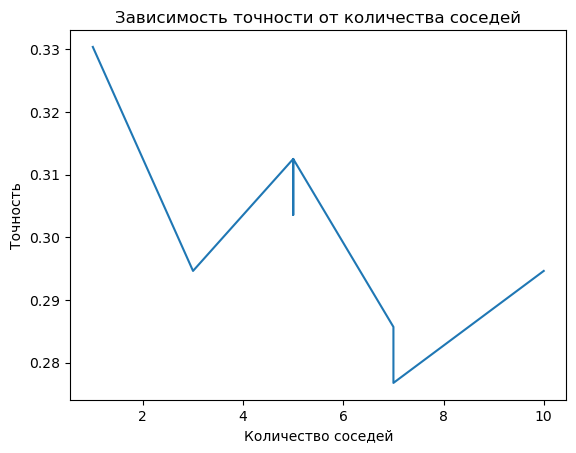

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

# Загрузка данных
data = pd.read_csv("data/salary.csv")

# Предобработка данных
data = data.dropna()  # Удалим строки с пропущенными значениями
# Кодируем категориальные данные
data['Gender'] = data['Gender'].map({'Male': 0, 'Female': 1})
education_map = {"Bachelor's": 0, "Master's": 1, "PhD": 2}
data['Education Level'] = data['Education Level'].map(education_map)

# Выбор признаков и целевой переменной
features = ['Age', 'Gender', 'Education Level', 'Years of Experience']
X = data[features]
y = data['Salary']

# Нормализация данных
X = (X - X.min()) / (X.max() - X.min())

# Разделение данных на тренировочные и тестовые наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

class KNearestNeighbors:
    def __init__(self, k=3, window_size=None, metric='euclidean', kernel='uniform', weights=None):
        self.k = k
        self.window_size = window_size
        self.metric = metric
        self.kernel = kernel
        self.weights = weights

    def _uniform_kernel(self, distances):
        return np.where(distances <= 1, 1, 0)

    def _gaussian_kernel(self, distances):
        return np.exp(-0.5 * (distances ** 2))

    def _triangular_kernel(self, distances):
        return np.clip(1 - np.abs(distances), 0, 1)

    def _general_kernel(self, distances, a=1, b=2):
        return np.power(1 - np.abs(distances) ** a, b)

    def _calculate_weights(self, distances):
        if self.kernel == 'uniform':
            return self._uniform_kernel(distances)
        elif self.kernel == 'gaussian':
            return self._gaussian_kernel(distances)
        elif self.kernel == 'triangular':
            return self._triangular_kernel(distances)
        elif self.kernel == 'general':
            return self._general_kernel(distances, a=1, b=2)
        else:
            raise ValueError("Unknown kernel type.")

    def _distance(self, x, y):
        if self.metric == 'cosine':
            return cosine(x, y)
        elif self.metric == 'euclidean':
            return np.linalg.norm(x - y)
        elif self.metric == 'chebyshev':
            return np.max(np.abs(x - y))
        elif self.metric.startswith('minkowski'):
            p = float(self.metric.split('_')[1])
            return np.linalg.norm(x - y, ord=p)
        else:
            raise ValueError("Unknown distance metric.")

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)

    def predict(self, X):
        X = np.array(X)
        predictions = []
        for x in X:
            # Вычисляем расстояния до всех обучающих объектов
            distances = np.array([self._distance(x, x_train) for x_train in self.X_train])
            sorted_indices = np.argsort(distances)
            neighbors_indices = sorted_indices[:self.k]

            # Веса для соседей
            weights = self._calculate_weights(distances[neighbors_indices])

            # Применяем веса
            if self.weights is not None:
                weights *= self.weights[:self.k]

            # Прогнозируем класс
            class_votes = {}
            for idx, weight in zip(neighbors_indices, weights):
                label = self.y_train[idx]
                if label not in class_votes:
                    class_votes[label] = 0
                class_votes[label] += weight

            # Находим класс с максимальным весом
            predicted_class = max(class_votes, key=class_votes.get)
            predictions.append(predicted_class)
        return np.array(predictions)

# Подбор гиперпараметров
def grid_search(X_train, y_train, X_test, y_test):
    best_params = None
    best_score = float('-inf')
    results = []
    for k in [1, 3, 5, 7, 10]:
        for metric in ['euclidean', 'cosine', 'chebyshev']:
            for kernel in ['uniform', 'gaussian', 'triangular', 'general']:
                knn = KNearestNeighbors(k=k, metric=metric, kernel=kernel)
                knn.fit(X_train, y_train)
                predictions = knn.predict(X_test)
                score = accuracy_score(y_test, predictions)
                results.append((k, metric, kernel, score))
                if score > best_score:
                    best_score = score
                    best_params = (k, metric, kernel)
    return best_params, results

best_params, results = grid_search(X_train, y_train, X_test, y_test)
print("Лучшие гиперпараметры:", best_params)

# Построение графика зависимости
scores = [r[3] for r in results if r[1] == 'euclidean']
ks = [r[0] for r in results if r[1] == 'euclidean']
plt.plot(ks, scores)
plt.xlabel("Количество соседей")
plt.ylabel("Точность")
plt.title("Зависимость точности от количества соседей")
plt.show()